# Transfer Learning

- Under this project image classification is done on CIFAR-10 dataset consisting of 60,000 32*32 color images of 10 classes distrubuted evenly as 6000 images per class. The dataset is a subset drawn from very large CIFAR datasett that has over 80  millinon images.
- Pretrained Resnet-50 weights are used for the network training excluding the input and output layer which is implemented according the our use case. Feature extractor and a classifier is stacked with the pretrained NN to generalize the 10 classes. 

### Imports

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.1


In [2]:
X = tf.constant([6, 3, 3, 3, 0, 1, 3, 6, 7])
res = tf.reduce_sum(tf.cast(tf.equal(X, 3), tf.int32))
with tf.compat.v1.Session() as sess:
    print(sess.run(res))

4


### Parameters
- define batch size
- define classes (category) names

In [15]:
BATCH_SIZE = 32
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#### Helper function to create visualizations

In [4]:
#@title Visualization Utilities[RUN ME] { vertical-output: true }
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

### Loading and Preprocessing Data

In [5]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

#### Visualize the loaded data

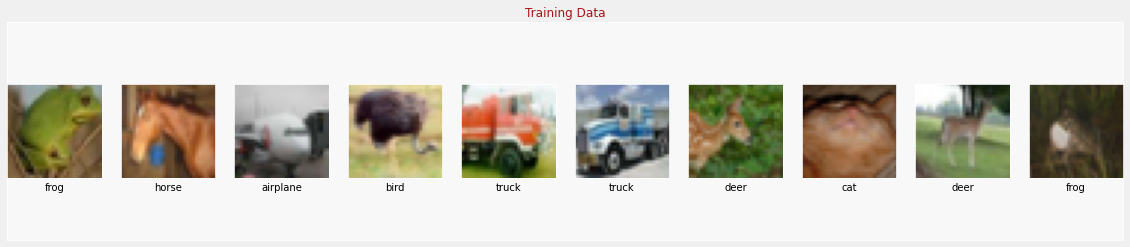

In [6]:
display_images(training_images, training_labels, training_labels, "Training Data" )

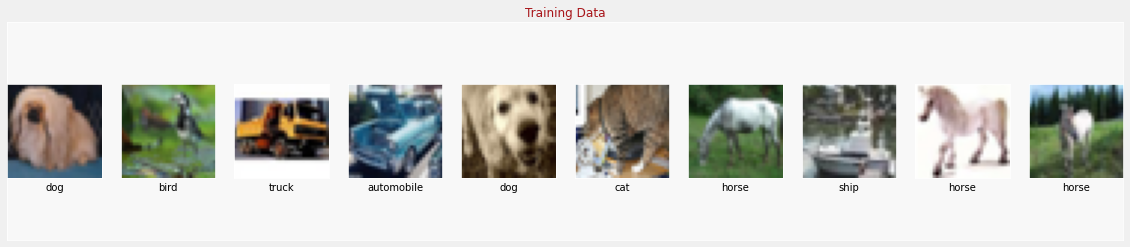

In [7]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

In [8]:
validation_images[0].astype('float32').shape

(32, 32, 3)

### Preprocess the dataset
- perform normalization on training and validation image set

In [9]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

### Defining the Network
- loading pretrained *imagenet weights* to the model
- retaining all layers of ResNet50 alongg with classification layers
- Fine tune the classification layer for objective of classifying 10 classes and training the classifier only.

In [10]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                       

### Start model training

In [16]:
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
EPOCHS = 4
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=32)

Train on 50000 samples, validate on 10000 samples
Epoch 1/4
50000/50000 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.8865

C:\Users\umang\anaconda3\envs\TF2.0\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


50000/50000 [==============================] - 651s 13ms/sample - loss: 0.3416 - accuracy: 0.8865 - val_loss: 0.1892 - val_accuracy: 0.9357
Epoch 2/4
50000/50000 [==============================] - 495s 10ms/sample - loss: 0.0938 - accuracy: 0.9686 - val_loss: 0.1346 - val_accuracy: 0.9553
Epoch 3/4
50000/50000 [==============================] - 487s 10ms/sample - loss: 0.0364 - accuracy: 0.9885 - val_loss: 0.2332 - val_accuracy: 0.9355
Epoch 4/4
50000/50000 [==============================] - 497s 10ms/sample - loss: 0.0188 - accuracy: 0.9937 - val_loss: 0.1545 - val_accuracy: 0.9554


### Model Evaluation
- loss and accuracy metrics and plotting performance curves

In [17]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

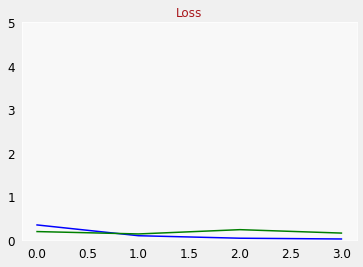

In [18]:
plot_metrics("loss", "Loss")

     training loss in blue and validation loss in green

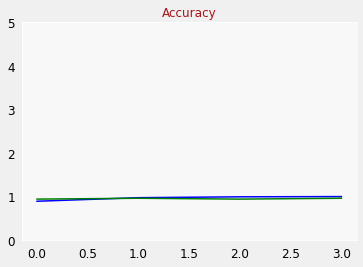

In [19]:
plot_metrics("accuracy", "Accuracy")

      training accuracy in blue and validation accuracy in green

### Predictions

C:\Users\umang\anaconda3\envs\TF2.0\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


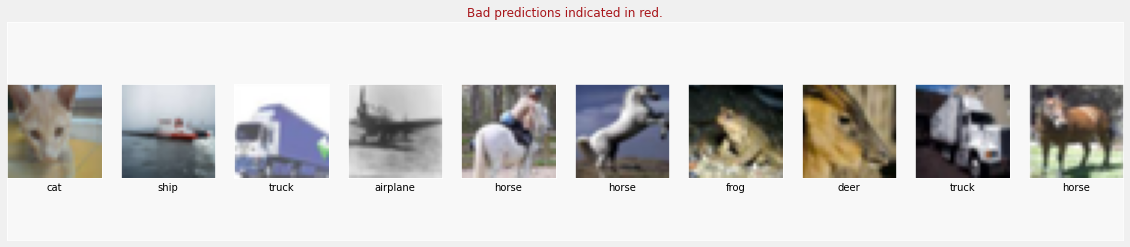

In [20]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")